In [121]:
from PIL import Image
import pandas as pd
import numpy as np
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

# Step 1: Data Cleaning(image compressing)

In [ ]:
def image_compressing():
    for i in range(1,3001):
        test = "000"+str(i)
        fn = test[len("000"+str(i)) - 4:len("000"+str(i))]
        filename = "/Users/jiangyiran/Downloads/train/images/" + fn +'.jpg'
        im = Image.open(filename)
        im = im.resize((200,200),Image.ANTIALIAS)
        im.save('/Users/jiangyiran/Downloads/train/compressed/'+fn+'.png')
image_compressing()

# Step 2: Data Cleaning(dividing data into test and training set)

In [ ]:
def data_dividing():
    x = [1,2,3]
    label = np.repeat(x,1000)
    np.random.seed(0)
    items = list(range(0,3000))
    random.shuffle(items)
    shuffledlabel = label[items]
    train = items[0:2700]
    test = items[2700:3001]
    for i in range(1,3001):
        test = "000"+str(i)
        fn = test[len("000"+str(i)) - 4:len("000"+str(i))]
        filename = "/Users/jiangyiran/Downloads/train/compressed/" + fn +'.png'
        im = Image.open(filename)
        t = i-1
        if t in train:
            if label[t] == 1:
                im.save('/Users/jiangyiran/Downloads/train/train/chicken/'+fn+'.png')
            if label[t] == 2:
                im.save('/Users/jiangyiran/Downloads/train/train/dog/'+fn+'.png')
            if label[t] == 3:
                im.save('/Users/jiangyiran/Downloads/train/train/muffin/'+fn+'.png')
        else:
            if label[t] == 1:
                im.save('/Users/jiangyiran/Downloads/train/val/chicken/'+fn+'.png')
            if label[t] == 2:
                im.save('/Users/jiangyiran/Downloads/train/val/dog/'+fn+'.png')
            if label[t] == 3:
                im.save('/Users/jiangyiran/Downloads/train/val/muffin/'+fn+'.png')
data_dividing()

# Step 3: Neural Network Training

In [124]:
#Source code http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/jiangyiran/Downloads/train'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

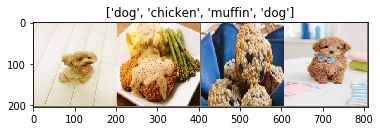

In [125]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [126]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# The training result

In [129]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3794 Acc: 0.8652
val Loss: 0.0507 Acc: 0.9833

Epoch 1/24
----------
train Loss: 0.2518 Acc: 0.9207
val Loss: 0.0543 Acc: 0.9800

Epoch 2/24
----------
train Loss: 0.2297 Acc: 0.9322
val Loss: 0.0363 Acc: 0.9867

Epoch 3/24
----------
train Loss: 0.2022 Acc: 0.9430
val Loss: 0.0528 Acc: 0.9833

Epoch 4/24
----------
train Loss: 0.1472 Acc: 0.9578
val Loss: 0.0524 Acc: 0.9933

Epoch 5/24
----------
train Loss: 0.1263 Acc: 0.9700
val Loss: 0.0383 Acc: 0.9900

Epoch 6/24
----------
train Loss: 0.1414 Acc: 0.9589
val Loss: 0.0762 Acc: 0.9767

Epoch 7/24
----------
train Loss: 0.0673 Acc: 0.9837
val Loss: 0.0452 Acc: 0.9800

Epoch 8/24
----------
train Loss: 0.0670 Acc: 0.9804
val Loss: 0.0488 Acc: 0.9800

Epoch 9/24
----------
train Loss: 0.0551 Acc: 0.9841
val Loss: 0.0676 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.0472 Acc: 0.9881
val Loss: 0.0321 Acc: 0.9900

Epoch 11/24
----------
train Loss: 0.0625 Acc: 0.9841
val Loss: 0.0390 Acc: 0.9833

Ep

# Step 4: CNN Training

In [138]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# The training result

In [139]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4188 Acc: 0.8244
val Loss: 0.0583 Acc: 0.9833

Epoch 1/24
----------
train Loss: 0.3350 Acc: 0.8770
val Loss: 0.0830 Acc: 0.9633

Epoch 2/24
----------
train Loss: 0.2962 Acc: 0.8944
val Loss: 0.0568 Acc: 0.9800

Epoch 3/24
----------
train Loss: 0.3317 Acc: 0.8781
val Loss: 0.0512 Acc: 0.9833

Epoch 4/24
----------
train Loss: 0.3060 Acc: 0.8896
val Loss: 0.0867 Acc: 0.9600

Epoch 5/24
----------
train Loss: 0.2631 Acc: 0.9078
val Loss: 0.0631 Acc: 0.9733

Epoch 6/24
----------
train Loss: 0.3146 Acc: 0.8904
val Loss: 0.1519 Acc: 0.9533

Epoch 7/24
----------
train Loss: 0.2187 Acc: 0.9189
val Loss: 0.1002 Acc: 0.9667

Epoch 8/24
----------
train Loss: 0.2348 Acc: 0.9167
val Loss: 0.0562 Acc: 0.9800

Epoch 9/24
----------
train Loss: 0.2423 Acc: 0.9115
val Loss: 0.1019 Acc: 0.9600

Epoch 10/24
----------
train Loss: 0.2319 Acc: 0.9148
val Loss: 0.1748 Acc: 0.9433

Epoch 11/24
----------
train Loss: 0.2308 Acc: 0.9148
val Loss: 0.0784 Acc: 0.9700

Ep